In [1]:
# importing the dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim
import gensim.downloader
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, Flatten, GlobalMaxPool1D, Bidirectional, GlobalAveragePooling1D
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.drop(columns=['label-fine'])
test_df = test_df.drop(columns=['label-fine'])

# Creating developmental set of 500 rows from train set
train_df, dev_df = train_test_split(train_df, test_size=(500/len(train_df)), random_state=42)

counts = train_df['label-coarse'].value_counts()

# Find the labels with the lowest frequencies
lowest_frequency = [counts.index[-1], counts.index[-2]]
print("Labels being merged to new category: ", lowest_frequency)
print("Merged into new category: ", lowest_frequency[0])

# Replace these labels with new label: 6
train_df.loc[(train_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
dev_df.loc[(dev_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
test_df.loc[(test_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]

train_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Labels being merged to new category:  [2, 5]
Merged into new category:  2


In [3]:
train_df

,label-coarse,text
0,2,What is Mikhail Gorbachev 's middle initial ?
1,0,How does the tail affect the flight of a kite ?
2,2,What were the first three cities to have a pop...
3,1,What is the movie Jonathan Livingstone Seagull ?
4,1,What is a fear of home surroundings ?
...,...,...
4947,4,How much Coca Cola is drunk in one day in the ...
4948,2,What cathedral was Thomas Becket murdered in ?
4949,3,What character in The Beverly Hillbillies has ...
4950,2,What does the River Seine empty into ?


In [4]:
# Takes about ~30 mins for first run, ~30 seconds afterwards
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
train_df['text'][0]

"What is Mikhail Gorbachev 's middle initial ?"

In [6]:
import nltk

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Tokenize the text using word_tokenize
train_df['text'] = train_df['text'].apply(word_tokenize)
dev_df['text'] = dev_df['text'].apply(word_tokenize)
test_df['text'] = test_df['text'].apply(word_tokenize)

In [9]:
train_df['text'][0]

['What', 'is', 'Mikhail', 'Gorbachev', "'s", 'middle', 'initial', '?']

In [10]:
# Count total number of unique tokens in the training data
unique_tokens = set()
train_df['text'].apply(unique_tokens.update)
# Remove words from the set which are not in the word2vec model
unique_tokens = unique_tokens.intersection(set(word2vec.key_to_index.keys()))
len(unique_tokens)

8170

In [11]:
tok = Tokenizer()
tok.fit_on_texts(train_df['text'])
train_df['text'] = tok.texts_to_sequences(train_df['text'])
dev_df['text'] = tok.texts_to_sequences(dev_df['text'])
test_df['text'] = tok.texts_to_sequences(test_df['text'])

In [12]:
train_df['text'][0]

[3, 4, 1435, 1091, 10, 461, 3214, 1]

In [13]:
X_train_sequences = train_df['text']
X_dev_sequences = dev_df['text']
X_test_sequences = test_df['text']

max_len = max([len(sentence) for sentence in train_df['text']])

# Pad sequences to a fixed length (if needed)
X_train_padded = pad_sequences(X_train_sequences, maxlen= max_len, padding='post', truncating='post')
X_dev_padded = pad_sequences(X_dev_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Get the y labels
y_train = train_df['label-coarse']
y_dev = dev_df['label-coarse']
y_test = test_df['label-coarse']

# Convert the labels to categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [14]:
X_train_padded[0], y_train[0]

(array([   3,    4, 1435, 1091,   10,  461, 3214,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32),
 array([0., 0., 1., 0., 0.], dtype=float32))

In [15]:
embedding_dim = len(word2vec['apple']) # Any word vector dimensionality

In [16]:
# Create a dictionary with the unqiue_tokens with the tokens as keys and interger values as values
word_index = {}
for i, token in enumerate(unique_tokens):
    word_index[token] = i

In [17]:
vocab_size = len(word_index) + 1

In [18]:
embedding_matrix = np.zeros(shape=(vocab_size, embedding_dim))

for word, i in word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [19]:
num_epochs = [10, 20]
batch_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001]
aggregation_methods = ['max', 'avg']

In [20]:
# Perform hyperparameter optimization

class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_accuracies.append(logs.get('accuracy'))
        self.eval_accuracies.append(logs.get('val_accuracy'))

accuracies = {}
test_accuracy = {}

for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for aggregation_method in aggregation_methods:
              # Initialize the list to store the training and eval accuracies
              accuracy_callback = AccuracyCallback()
              accuracies[(num_epoch, batch_size, learning_rate, aggregation_method)] = accuracy_callback

              aggregation = GlobalMaxPool1D() if aggregation_method == 'max' else GlobalAveragePooling1D()

              model = Sequential([
                  Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix), trainable=False),
                  Bidirectional(LSTM(256, return_sequences=True)),
                  Dropout(0.2),
                  Bidirectional(LSTM(64, return_sequences=True)),
                  Dropout(0.2),
                  aggregation,
                  Dense(5, activation='softmax')
              ])

              # Train and store the accuracies
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
              model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
              model.fit(X_train_padded, y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_dev_padded, y_dev), callbacks=[accuracy_callback])

              # Evaluate the model on the test data
              loss, accuracy = model.evaluate(X_test_padded, y_test)
              test_accuracy[(num_epoch, batch_size, learning_rate, aggregation_method)] = accuracy

Epoch 1/10
155/155 [==============================] - 32s 33ms/step - loss: 1.2475 - accuracy: 0.4853 - val_loss: 1.0347 - val_accuracy: 0.5480
Epoch 2/10
155/155 [==============================] - 3s 20ms/step - loss: 0.9419 - accuracy: 0.6327 - val_loss: 0.9018 - val_accuracy: 0.6580
Epoch 3/10
155/155 [==============================] - 3s 19ms/step - loss: 0.7720 - accuracy: 0.7001 - val_loss: 0.7019 - val_accuracy: 0.7280
Epoch 4/10
155/155 [==============================] - 3s 20ms/step - loss: 0.6228 - accuracy: 0.7647 - val_loss: 0.6101 - val_accuracy: 0.7760
Epoch 5/10
155/155 [==============================] - 3s 21ms/step - loss: 0.4780 - accuracy: 0.8282 - val_loss: 0.5436 - val_accuracy: 0.7940
Epoch 6/10
155/155 [==============================] - 3s 19ms/step - loss: 0.3517 - accuracy: 0.8825 - val_loss: 0.4762 - val_accuracy: 0.8160
Epoch 7/10
155/155 [==============================] - 3s 22ms/step - loss: 0.2564 - accuracy: 0.9118 - val_loss: 0.4130 - val_accuracy: 0.848

In [21]:
test_accuracy

{(10, 32, 0.01, 'max'): 0.8859999775886536,
 (10, 32, 0.01, 'avg'): 0.8539999723434448,
 (10, 32, 0.001, 'max'): 0.8460000157356262,
 (10, 32, 0.001, 'avg'): 0.8560000061988831,
 (10, 64, 0.01, 'max'): 0.8679999709129333,
 (10, 64, 0.01, 'avg'): 0.8640000224113464,
 (10, 64, 0.001, 'max'): 0.8240000009536743,
 (10, 64, 0.001, 'avg'): 0.8560000061988831,
 (10, 128, 0.01, 'max'): 0.8679999709129333,
 (10, 128, 0.01, 'avg'): 0.8339999914169312,
 (10, 128, 0.001, 'max'): 0.8259999752044678,
 (10, 128, 0.001, 'avg'): 0.8320000171661377,
 (20, 32, 0.01, 'max'): 0.8859999775886536,
 (20, 32, 0.01, 'avg'): 0.8579999804496765,
 (20, 32, 0.001, 'max'): 0.8339999914169312,
 (20, 32, 0.001, 'avg'): 0.8640000224113464,
 (20, 64, 0.01, 'max'): 0.878000020980835,
 (20, 64, 0.01, 'avg'): 0.8679999709129333,
 (20, 64, 0.001, 'max'): 0.8560000061988831,
 (20, 64, 0.001, 'avg'): 0.8500000238418579,
 (20, 128, 0.01, 'max'): 0.8539999723434448,
 (20, 128, 0.01, 'avg'): 0.8659999966621399,
 (20, 128, 0.001,

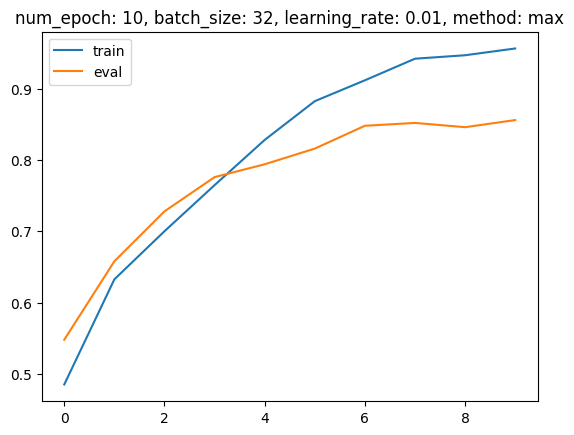

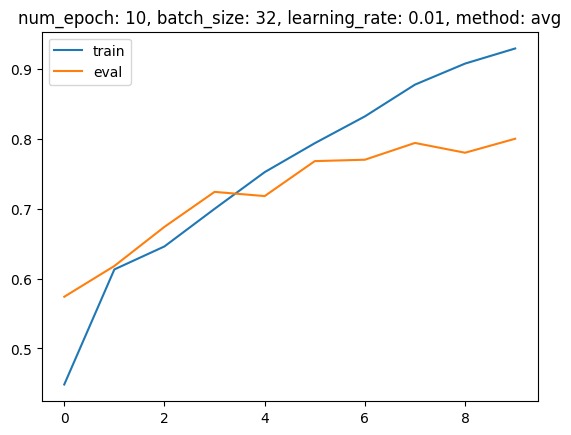

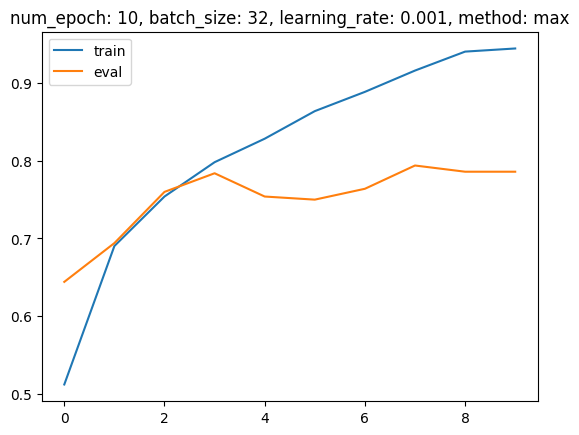

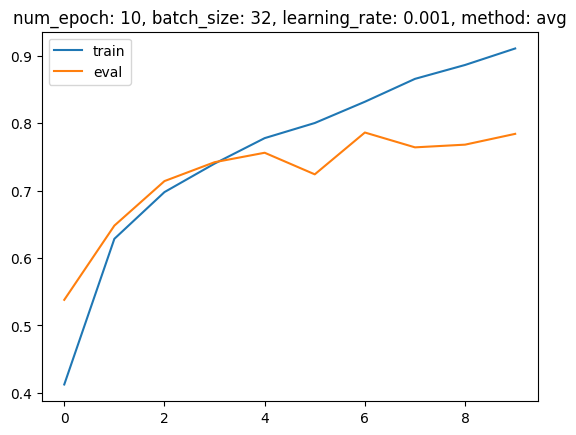

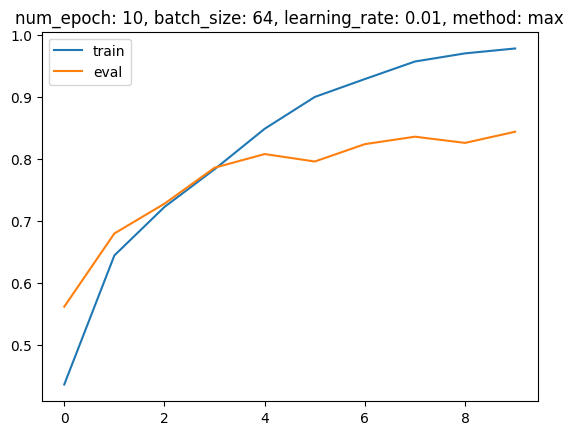

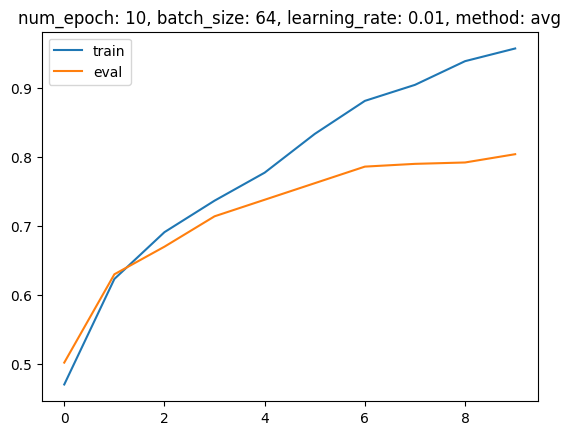

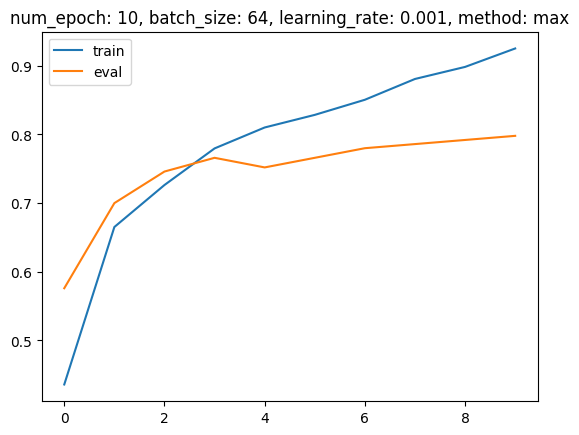

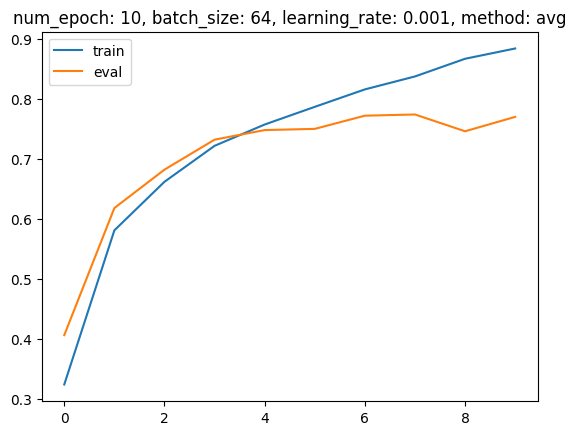

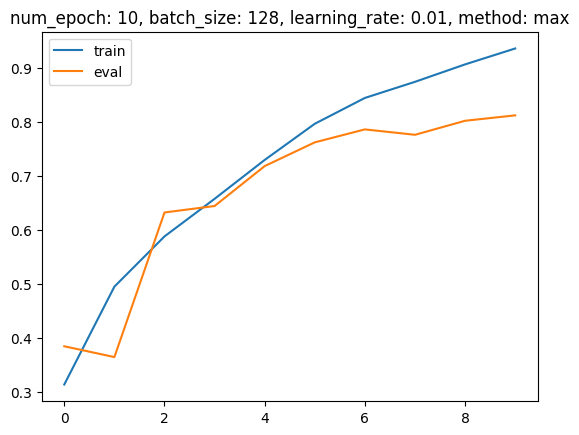

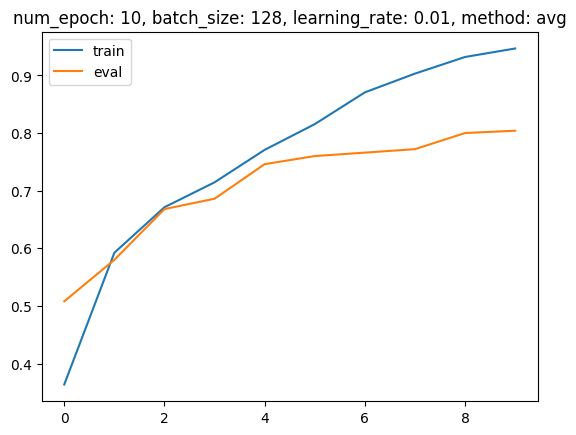

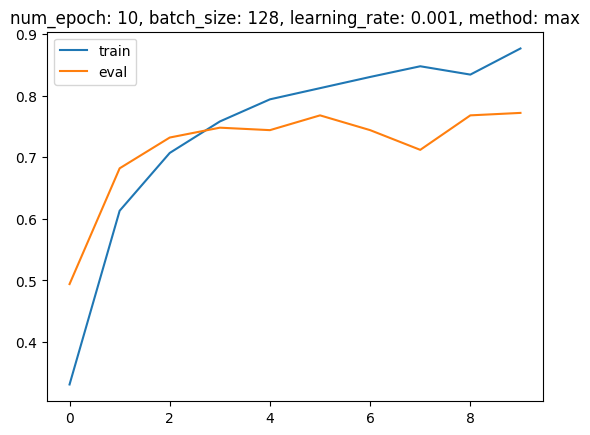

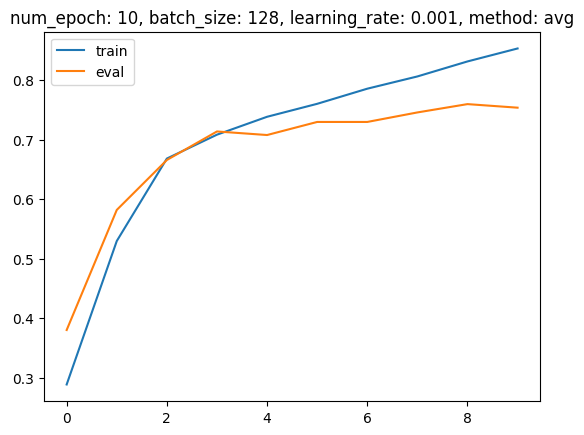

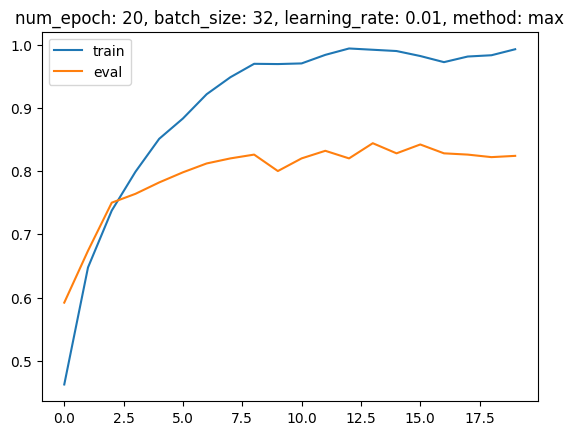

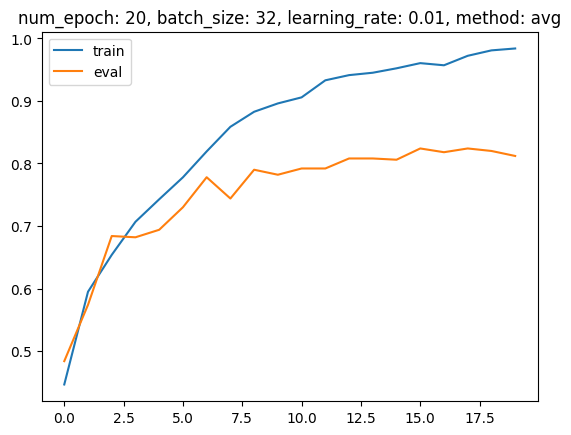

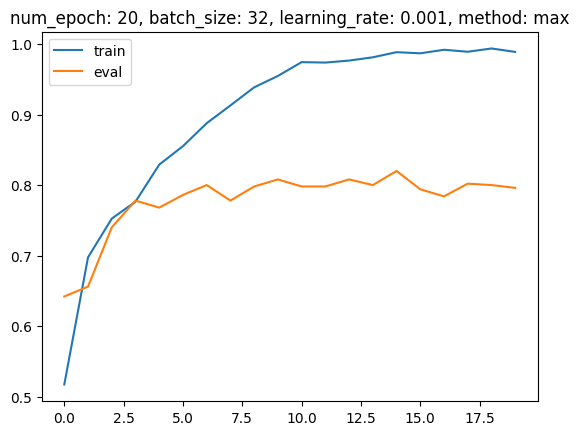

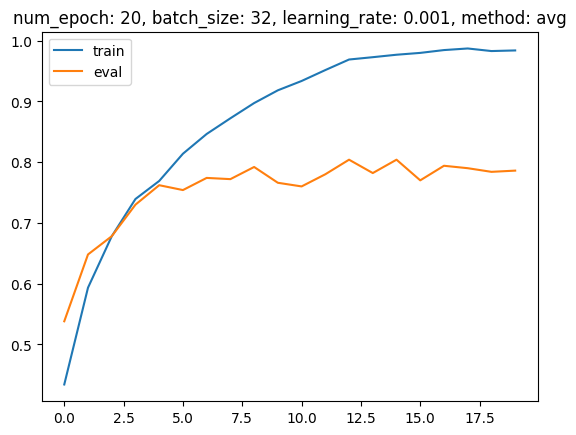

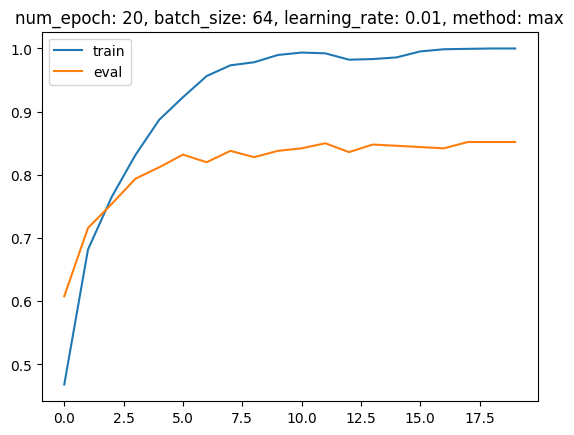

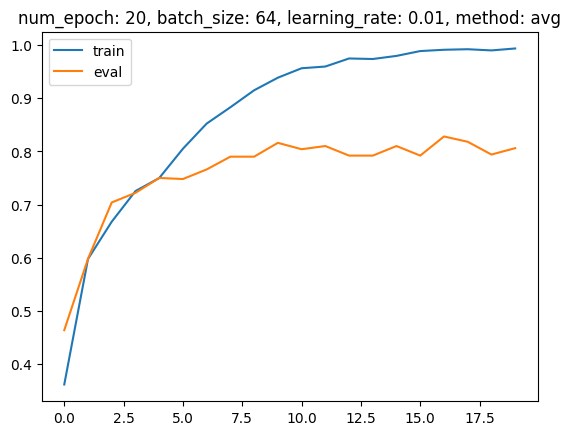

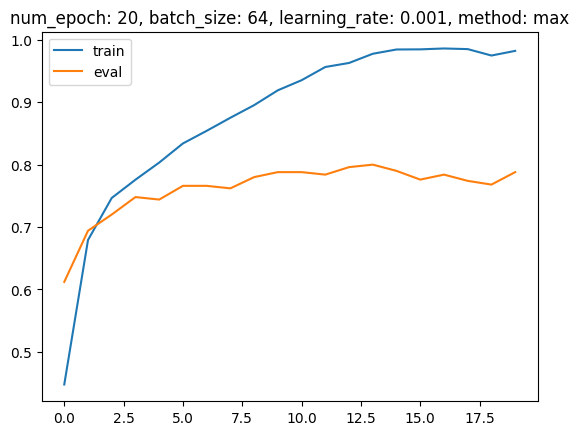

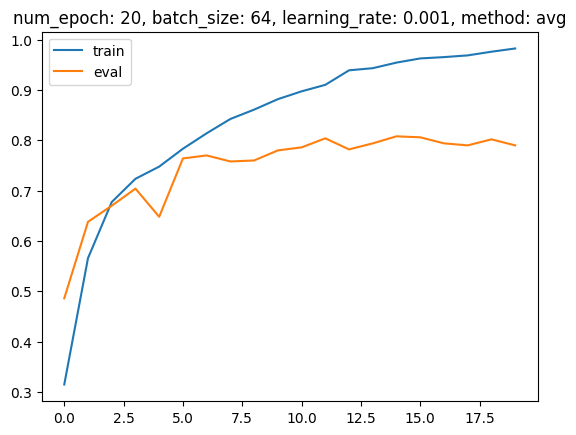

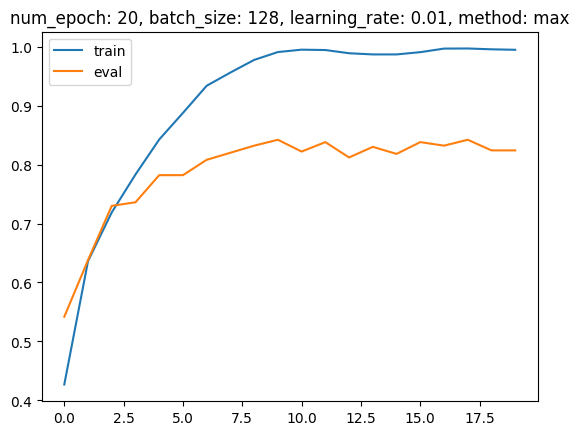

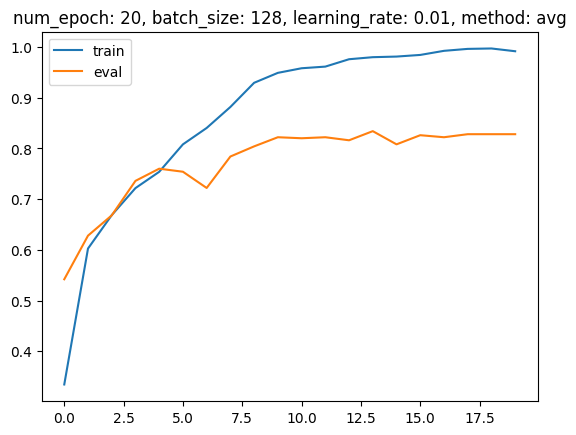

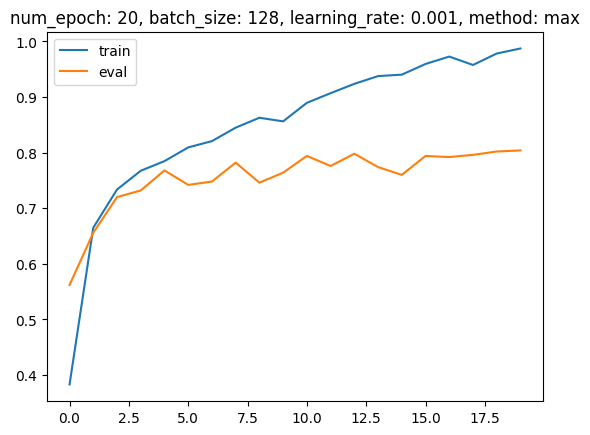

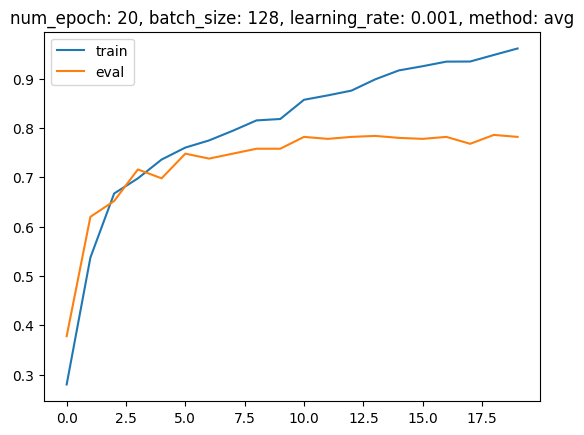

In [23]:
import matplotlib.pyplot as plt

# Plot the training and eval accuracies for each hyperparameter combination
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for aggregation_method in aggregation_methods:
              accuracy_callback = accuracies[(num_epoch, batch_size, learning_rate, aggregation_method)]
              plt.plot(accuracy_callback.train_accuracies, label='train')
              plt.plot(accuracy_callback.eval_accuracies, label='eval')
              plt.title("num_epoch: {}, batch_size: {}, learning_rate: {}, method: {}".format(num_epoch, batch_size, learning_rate, aggregation_method))
              plt.legend()
              plt.show()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.01, method: max'),
  Text(1, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.01, method: avg'),
  Text(2, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.001, method: max'),
  Text(3, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.001, method: avg'),
  Text(4, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.01, method: max'),
  Text(5, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.01, method: avg'),
  Text(6, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.001, method: max'),
  Text(7, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.001, method: avg'),
  Text(8, 0, 'num_epoch: 10, batch_size: 128, learning_rate: 0.01, method: max'),
  Text(9, 0, 'num_epoch: 10, batch_size: 128, learning_rate: 0.01, method: avg'),
  Text(10, 0, 'num_epoch: 10, batch_size: 128, le

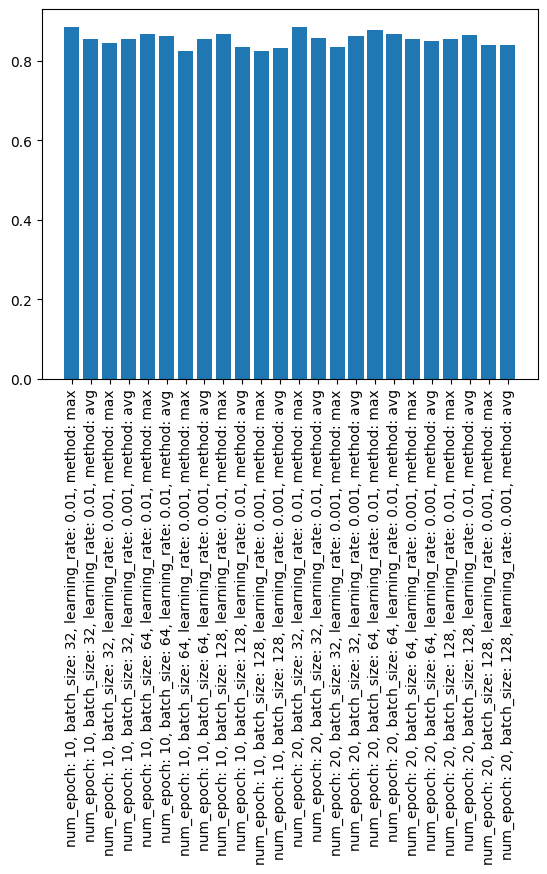

In [25]:
# Plot the test accuracies for each hyperparameter combination and label the x-axis accordingly
x_axis = []
y_axis = []
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for aggregation_method in aggregation_methods:
                x_axis.append("num_epoch: {}, batch_size: {}, learning_rate: {}, method: {}".format(num_epoch, batch_size, learning_rate, aggregation_method))
                y_axis.append(test_accuracy[(num_epoch, batch_size, learning_rate, aggregation_method)])

# Make the x-axis labels vertical
plt.bar(x_axis, y_axis)
plt.xticks(rotation=90)